In [1]:
import librosa
import librosa.display
import numpy as np 
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wavio
import IPython.display

import utils
import plot

/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
raw_specs, noised_specs = utils.load_spectrograms("../data")

In [3]:
raw_specs[2].shape

(128, 95)

In [333]:
input_dim = 128  # 128次元のメルスペクトログラム

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()


        self.linear1 = nn.Linear(input_dim, input_dim*2)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(input_dim*2, output_dim)
        self.act2 = nn.Tanh()
        
        
        
    def forward(self, x):
        """
        Input:
        x (torch.Tensor): (N, input_dim).
        Output:
        y (torch.Tensor): (N, output_dim).
        """
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x
        

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.act2 = nn.Sigmoid()
        
        self.norm = nn.LayerNorm(output_dim)
        
    def forward(self, x):
        """
        Input:
        x (torch.Tensor): (N, input_dim).
        Output:
        y (torch.Tensor): (N, output_dim).
        """
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x

In [334]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=128, diff=1):
        """
        input_dim: 入力次元.128*3くらい
        hidden_dim: 隠れ次元情報としてどこまで圧縮するか
        output_dim: 出力次元。128で今回は固定
        ddof: 何次元まで差分をとっているか
        """
        super(Model, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(hidden_dim, output_dim)
        self.pad = nn.ReplicationPad2d((0, 0, diff, diff))
        self.diff = diff
        
        
    def forward(self, x, train=True):
        x = self.encoder(x)
        x = self.decoder(x)
        if not train:
            T = x.size()[0]  # length of time
            F = x.size()[1]  # num feature 
            x = x.view(1, 1, T, F)
            x = self.pad(x)
            x = x.view(T+self.diff*2, F)
        return x

In [386]:
class SpecDataset(Dataset):
    def __init__(self, specs, diff=1, train=True):
        self.specs = specs
        self.diff = diff
        self.train = train
        if diff not in [0, 1]:
            raise NotImplementError
        xs = []
        ys = []
        for idx, spec in specs.items():
            spec = spec.T
            spec /= spec.max()
            y = spec.copy()
            if self.diff == 1:
                tmp = spec.copy()
                spec = np.zeros((spec.shape[0]-2, 3, spec.shape[1]), dtype=spec.dtype)
                spec[:, 0, :] = tmp[1:-1]
                spec[:, 1, :] = tmp[1:-1] - tmp[:-2]
                spec[:, 2, :] = tmp[2:] - tmp[1:-1]
                spec = spec.reshape(spec.shape[0], -1)
            elif self.diff == 0:
                pass
            x = spec
            xs.append(x)
            ys.append(y)
        self.xs = np.concatenate(xs, axis=0)
        self.ys = np.concatenate(ys, axis=0)
            
    
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, idx):
        if not self.train:
            spec = self.specs[idx+1].T
            y = torch.Tensor(spec.copy())
            if self.diff == 1:
                tmp = spec.copy()
                spec = np.zeros((spec.shape[0]-2, 3, spec.shape[1]), dtype=spec.dtype)
                spec[:, 0, :] = tmp[1:-1]
                spec[:, 1, :] = tmp[1:-1] - tmp[:-2]
                spec[:, 2, :] = tmp[2:] - tmp[1:-1]
                spec = spec.reshape(spec.shape[0], -1)
            x = torch.Tensor(spec)
        else:
            x = torch.Tensor(self.xs[idx])
            y = torch.Tensor(self.ys[idx])
        return {"x": x, "y": y}

In [387]:
mel_dim = 128
hidden_dim = 32
diff = 0
input_dim = mel_dim * (1 + 2*diff)
model = Model(input_dim, hidden_dim, mel_dim, diff=diff)
train_dataset = SpecDataset(raw_specs, train=True, diff=diff)
test_dataset = SpecDataset(noised_specs, train=False, diff=diff)

In [403]:
lr = 1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [404]:
dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [405]:
train_dataset.xs.shape

(21345, 128)

In [406]:
epochs = 300
name = "FullyConnectedAutoEncoder_diff0"
loss_record  = []
test_loss_record = []
for epoch in range(epochs):
    train_idxs = np.arange(len(train_dataset))
    np.random.shuffle(train_idxs)
    test_idxs = np.arange(len(test_dataset))
    running_loss = 0.0
    train_results = {}
    for i, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs['x'], train=True)
        loss = criterion(outputs, inputs['y'])
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        running_loss += loss.item()
        train_results[idx+1] = outputs.detach().cpu().numpy()
        
    print('[%d] train loss: %.3e' % (epoch+1, running_loss))
    running_loss = 0.0
    eval_results = {}
    for i, idx in enumerate(test_idxs):
        inputs = test_dataset[idx]
        with torch.no_grad():
            outputs = model(inputs['x'], train=False)
            loss = criterion(outputs, inputs['y'])
        running_loss += loss.item()
        scale = noised_specs[idx+1].max()
        eval_results[idx+1] = outputs.cpu().numpy()*scale
        test_loss_record.append(loss.item())
    print('[%d] test loss: %.3e' % (epoch+1, running_loss/len(test_idxs)))
    save_dir = f"../out/{name}/{epoch:02d}"
    utils.save_specs(eval_results, save_dir=os.path.join(save_dir, "noised_tgt"))
    utils.save_specs(train_results, save_dir=os.path.join(save_dir, "raw"))
    

[1] train loss: 5.599e-04
[1] test loss: 6.005e-04
[2] train loss: 5.587e-04
[2] test loss: 5.994e-04
[3] train loss: 5.575e-04
[3] test loss: 5.982e-04
[4] train loss: 5.563e-04
[4] test loss: 5.970e-04
[5] train loss: 5.552e-04
[5] test loss: 5.959e-04
[6] train loss: 5.540e-04
[6] test loss: 5.948e-04
[7] train loss: 5.529e-04
[7] test loss: 5.937e-04
[8] train loss: 5.518e-04
[8] test loss: 5.926e-04
[9] train loss: 5.507e-04
[9] test loss: 5.915e-04
[10] train loss: 5.496e-04
[10] test loss: 5.904e-04
[11] train loss: 5.485e-04
[11] test loss: 5.894e-04
[12] train loss: 5.474e-04
[12] test loss: 5.883e-04
[13] train loss: 5.464e-04
[13] test loss: 5.873e-04
[14] train loss: 5.454e-04
[14] test loss: 5.863e-04
[15] train loss: 5.443e-04
[15] test loss: 5.853e-04
[16] train loss: 5.433e-04
[16] test loss: 5.843e-04
[17] train loss: 5.423e-04
[17] test loss: 5.833e-04
[18] train loss: 5.413e-04
[18] test loss: 5.824e-04
[19] train loss: 5.404e-04
[19] test loss: 5.814e-04
[20] train 

[154] train loss: 4.674e-04
[154] test loss: 5.122e-04
[155] train loss: 4.671e-04
[155] test loss: 5.119e-04
[156] train loss: 4.668e-04
[156] test loss: 5.117e-04
[157] train loss: 4.665e-04
[157] test loss: 5.114e-04
[158] train loss: 4.662e-04
[158] test loss: 5.111e-04
[159] train loss: 4.659e-04
[159] test loss: 5.109e-04
[160] train loss: 4.656e-04
[160] test loss: 5.106e-04
[161] train loss: 4.653e-04
[161] test loss: 5.103e-04
[162] train loss: 4.650e-04
[162] test loss: 5.101e-04
[163] train loss: 4.647e-04
[163] test loss: 5.098e-04
[164] train loss: 4.645e-04
[164] test loss: 5.096e-04
[165] train loss: 4.642e-04
[165] test loss: 5.093e-04
[166] train loss: 4.639e-04
[166] test loss: 5.091e-04
[167] train loss: 4.636e-04
[167] test loss: 5.088e-04
[168] train loss: 4.633e-04
[168] test loss: 5.086e-04
[169] train loss: 4.631e-04
[169] test loss: 5.083e-04
[170] train loss: 4.628e-04
[170] test loss: 5.081e-04
[171] train loss: 4.625e-04
[171] test loss: 5.078e-04
[172] trai

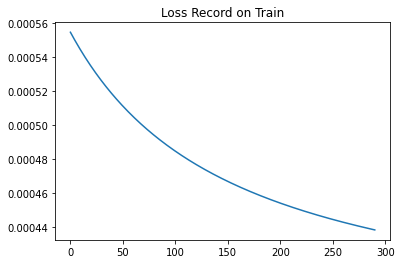

In [407]:
plt.title("Loss Record on Train")
plt.plot(np.convolve(loss_record, np.ones(10)/10.0, mode='valid'))

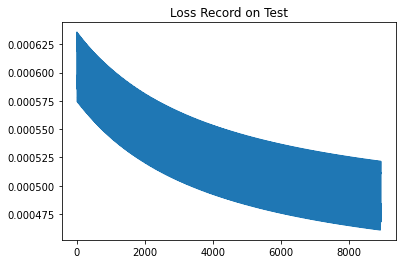

In [408]:
plt.title("Loss Record on Test")
plt.plot(np.convolve(test_loss_record, np.ones(40)/40.0, mode='valid'))

In [409]:
outputs.cpu().numpy().T.min()

0.006230887

In [410]:
inputs['y'].min(), inputs['y'].max()

(tensor(2.1605e-15), tensor(1.))

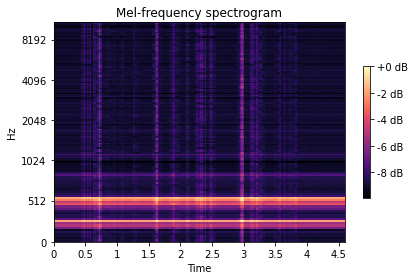

In [411]:
plot.plot_spectrogram(outputs.cpu().numpy().T)

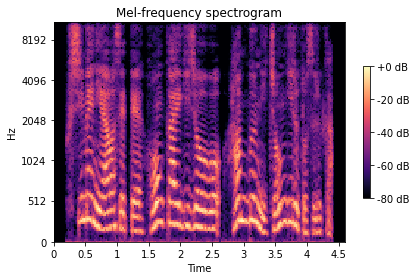

In [412]:
plot.plot_spectrogram(inputs['y'].cpu().numpy().T)

In [285]:
max_ = 0
for idx in raw_specs:
    max_ = max(max_, raw_specs[idx].max())

In [286]:
max_

413.4232510032508

In [13]:
criterion(outputs, inputs['y']).item()

11.509880065917969

In [67]:
spec = torch.Tensor(spec.T)
new_spec = model(spec, train=False)

In [69]:
train_dataset = SpecDataset(raw_specs)

In [71]:
train_dataset[1]['spec'].shape

torch.Size([93, 384])